In [3]:
# General Imports
import tensorflow as tf
import os
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt

# Model Training related Imports
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [5]:
# Importing Dataset
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
data_path, _ = os.path.splitext(zip_path)

In [8]:
# CSV to DataFrame
DataFrame = pd.read_csv(data_path)

#Taking every every hour intervel from the dataset
DataFrame = DataFrame[0::3]

# set index
DataFrame.index = pd.to_datetime(DataFrame['Date Time'], format='%d.%m.%Y %H:%M:%S')

DataFrame.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,,
2009-01-01 00:10:00,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
2009-01-01 00:40:00,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
2009-01-01 01:10:00,01.01.2009 01:10:00,996.50,-7.62,265.81,-8.30,94.8,3.44,3.26,0.18,2.04,3.27,1305.68,0.18,0.63,166.5
2009-01-01 01:40:00,01.01.2009 01:40:00,996.53,-8.43,264.99,-9.34,93.1,3.23,3.00,0.22,1.88,3.02,1309.85,0.59,0.88,185.0
2009-01-01 02:10:00,01.01.2009 02:10:00,996.63,-8.85,264.57,-9.70,93.5,3.12,2.92,0.20,1.82,2.93,1312.11,0.16,0.50,158.3


<AxesSubplot:xlabel='Date Time'>

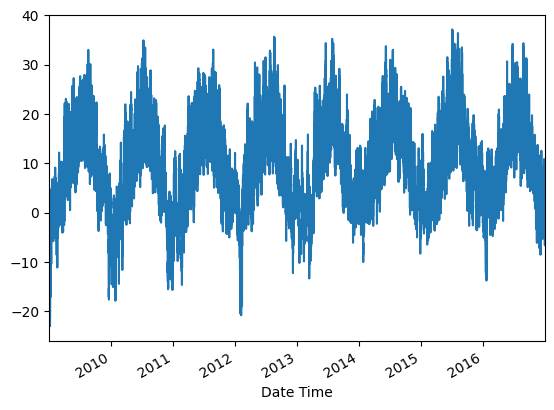

In [144]:
temprature = DataFrame['T (degC)']

temprature.plot()

In [167]:
# Funtion to create input and output from DataFrame

#[[[t1], [t2], [t3], [t4], [t5]] [t6]]

def DataFrame_to_input_output(DataFrame, windiw_size, variate):

    # Converting DataFrame to Numpy
    DataFrame_as_np = DataFrame.to_numpy()

    # Declaring Input and Output Lists
    Input_X = []
    Output_Y = []

    # Looping in Dataset to make Inputs and Outputs for next steps
    for k in range(len(DataFrame_as_np)-windiw_size):

        # Taking first window size values as Input
        instance = [x for x in DataFrame_as_np[k:k+windiw_size]]
        
        if(variate == "single"):
            instance = [[x] for x in DataFrame_as_np[k:k+windiw_size]]

        Input_X.append(instance)


        if(variate == "single"):
            Output_Y.append(DataFrame_as_np[k+windiw_size])

        if(variate == "multi_variables"):
            Output_Y.append(DataFrame_as_np[k+windiw_size][0])
            
        if(variate == "multi_Output"):
            Output_Y.append([DataFrame_as_np[k+windiw_size][0], DataFrame_as_np[k+windiw_size][1]])

    return np.asarray(Input_X).astype(np.float32), np.asarray(Output_Y).astype(np.float32)


In [146]:
# Making input (X) and output (Y) from Dataset

windiw_size = 5
Input, Output = DataFrame_to_input_output(temprature, windiw_size, variate="single")
Input.shape, Output.shape

((140179, 5, 1), (140179,))

In [147]:
# Data Split

Input_train, Output_train = Input[:120000], Output[:120000]
Input_val, Output_val = Input[120000:125000], Output[120000:125000]
Input_test, Output_test = Input[125000:], Output[125000:]




print(Input_train.shape, Output_train.shape)
print(Input_val.shape, Output_val.shape)
print(Input_test.shape, Output_test.shape)

(120000, 5, 1) (120000,)
(5000, 5, 1) (5000,)
(15179, 5, 1) (15179,)


In [148]:
# Defining LSTM Model

LSTM_model = Sequential()
LSTM_model.add(InputLayer((5, 1)))
LSTM_model.add(LSTM(64))
LSTM_model.add(Dense(8, 'relu'))
LSTM_model.add(Dense(1, 'linear'))

# Loss and optimizer
LSTM_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

LSTM_model.summary()


Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 64)                16896     
_________________________________________________________________
dense_28 (Dense)             (None, 8)                 520       
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 9         
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [149]:
# Training LSTM model
LSTM_model.fit(Input_train, Output_train, validation_data=(Input_val, Output_val), epochs=10)

Epoch 1/10
3750/3750 [==============================] - 36s 8ms/step - loss: 13.6058 - root_mean_squared_error: 3.1516 - val_loss: 0.1889 - val_root_mean_squared_error: 0.4347
Epoch 2/10
3750/3750 [==============================] - 24s 7ms/step - loss: 0.2683 - root_mean_squared_error: 0.5179 - val_loss: 0.1625 - val_root_mean_squared_error: 0.4031
Epoch 3/10
3750/3750 [==============================] - 23s 6ms/step - loss: 0.2626 - root_mean_squared_error: 0.5124 - val_loss: 0.1657 - val_root_mean_squared_error: 0.4071
Epoch 4/10
3750/3750 [==============================] - 25s 7ms/step - loss: 0.2606 - root_mean_squared_error: 0.5103 - val_loss: 0.1613 - val_root_mean_squared_error: 0.4016
Epoch 5/10
3750/3750 [==============================] - 23s 6ms/step - loss: 0.2560 - root_mean_squared_error: 0.5059 - val_loss: 0.1617 - val_root_mean_squared_error: 0.4022
Epoch 6/10
3750/3750 [==============================] - 31s 8ms/step - loss: 0.2527 - root_mean_squared_error: 0.5027 - val_

Text(0.5, 1.0, 'LSTM Results')

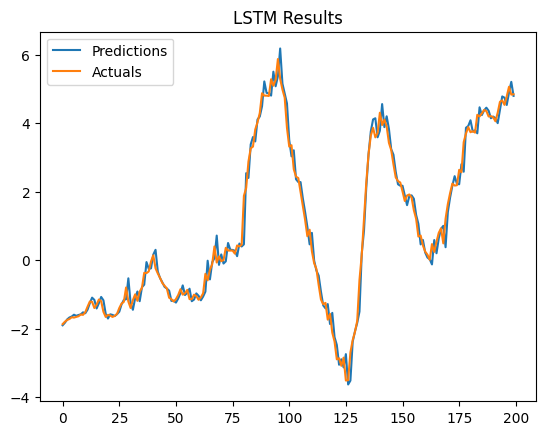

In [150]:
# Testing the LSTM model 
predictions = LSTM_model.predict(Input_test).flatten()
results = pd.DataFrame(data={'Predictions':predictions, 'Actuals':Output_test})

# Ploting the Results of 200 example
plt.plot(results['Predictions'][:200], label="Predictions")
plt.plot(results['Actuals'][:200], label="Actuals")
plt.legend(loc="upper left")
plt.title("LSTM Results")



In [151]:
# Defining GRU Model

GRU_model = Sequential()
GRU_model.add(InputLayer((5, 1)))
GRU_model.add(GRU(64))
GRU_model.add(Dense(8, 'relu'))
GRU_model.add(Dense(1, 'linear'))

# Loss and optimizer
GRU_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

GRU_model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_3 (GRU)                  (None, 64)                12864     
_________________________________________________________________
dense_30 (Dense)             (None, 8)                 520       
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 9         
Total params: 13,393
Trainable params: 13,393
Non-trainable params: 0
_________________________________________________________________


In [152]:
# Training GRU model
GRU_model.fit(Input_train, Output_train, validation_data=(Input_val, Output_val), epochs=10)

Epoch 1/10
3750/3750 [==============================] - 25s 6ms/step - loss: 7.7530 - root_mean_squared_error: 2.3257 - val_loss: 0.1766 - val_root_mean_squared_error: 0.4202
Epoch 2/10
3750/3750 [==============================] - 23s 6ms/step - loss: 0.2654 - root_mean_squared_error: 0.5151 - val_loss: 0.1659 - val_root_mean_squared_error: 0.4074
Epoch 3/10
3750/3750 [==============================] - 21s 6ms/step - loss: 0.2649 - root_mean_squared_error: 0.5146 - val_loss: 0.1645 - val_root_mean_squared_error: 0.4056
Epoch 4/10
3750/3750 [==============================] - 21s 6ms/step - loss: 0.2586 - root_mean_squared_error: 0.5086 - val_loss: 0.1632 - val_root_mean_squared_error: 0.4040
Epoch 5/10
3750/3750 [==============================] - 21s 6ms/step - loss: 0.2564 - root_mean_squared_error: 0.5063 - val_loss: 0.1881 - val_root_mean_squared_error: 0.4337
Epoch 6/10
3750/3750 [==============================] - 21s 6ms/step - loss: 0.2598 - root_mean_squared_error: 0.5097 - val_l

Text(0.5, 1.0, 'GRU Results')

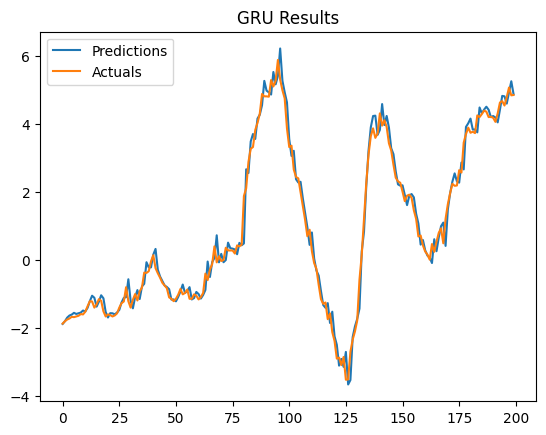

In [153]:
# Testing the GRU model 
predictions = GRU_model.predict(Input_test).flatten()
results = pd.DataFrame(data={'Predictions':predictions, 'Actuals':Output_test})

# Ploting the Results of 200 example
plt.plot(results['Predictions'][:200], label="Predictions")
plt.plot(results['Actuals'][:200], label="Actuals")
plt.legend(loc="upper left")
plt.title("GRU Results")


In [154]:
# Defining CNN Model

CNN_model = Sequential()
CNN_model.add(InputLayer((5, 1)))
CNN_model.add(Conv1D(64, kernel_size=2))
CNN_model.add(Flatten())
CNN_model.add(Dense(8, 'relu'))
CNN_model.add(Dense(1, 'linear'))

# Loss and optimizer
CNN_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

CNN_model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 4, 64)             192       
_________________________________________________________________
flatten_2 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 8)                 2056      
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 9         
Total params: 2,257
Trainable params: 2,257
Non-trainable params: 0
_________________________________________________________________


In [155]:
# Training CNN model
CNN_model.fit(Input_train, Output_train, validation_data=(Input_val, Output_val), epochs=10)

Epoch 1/10
3750/3750 [==============================] - 10s 2ms/step - loss: 8.0152 - root_mean_squared_error: 2.3090 - val_loss: 0.1695 - val_root_mean_squared_error: 0.4118
Epoch 2/10
3750/3750 [==============================] - 9s 2ms/step - loss: 0.2816 - root_mean_squared_error: 0.5306 - val_loss: 0.1702 - val_root_mean_squared_error: 0.4126
Epoch 3/10
3750/3750 [==============================] - 9s 2ms/step - loss: 0.2761 - root_mean_squared_error: 0.5254 - val_loss: 0.1854 - val_root_mean_squared_error: 0.4306
Epoch 4/10
3750/3750 [==============================] - 9s 2ms/step - loss: 0.2703 - root_mean_squared_error: 0.5199 - val_loss: 0.1666 - val_root_mean_squared_error: 0.4082
Epoch 5/10
3750/3750 [==============================] - 9s 2ms/step - loss: 0.2723 - root_mean_squared_error: 0.5218 - val_loss: 0.1786 - val_root_mean_squared_error: 0.4226
Epoch 6/10
3750/3750 [==============================] - 10s 3ms/step - loss: 0.2703 - root_mean_squared_error: 0.5198 - val_loss:

Text(0.5, 1.0, 'CNN Results')

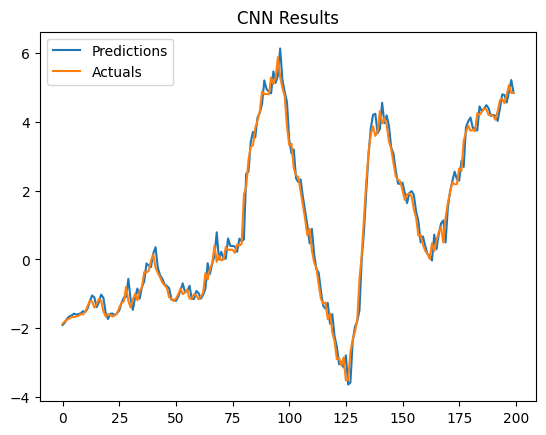

In [156]:
# Testing the CNN model 
predictions = CNN_model.predict(Input_test).flatten()
results = pd.DataFrame(data={'Predictions':predictions, 'Actuals':Output_test})

# Ploting the Results of 200 example
plt.plot(results['Predictions'][:200], label="Predictions")
plt.plot(results['Actuals'][:200], label="Actuals")
plt.legend(loc="upper left")
plt.title("CNN Results")


In [157]:
temprature_DataFrame = pd.DataFrame({'Temperature': temprature})

# create new second field in temprature_DataFrame
temprature_DataFrame["Seconds"] = temprature_DataFrame.index.map(pd.Timestamp.timestamp)

# Printing first 5 rows
temprature_DataFrame.head()

,Temperature,Seconds
Date Time,,
2009-01-01 00:10:00,-8.02,1.230769e+09
2009-01-01 00:40:00,-8.31,1.230770e+09
2009-01-01 01:10:00,-7.62,1.230772e+09
2009-01-01 01:40:00,-8.43,1.230774e+09
2009-01-01 02:10:00,-8.85,1.230776e+09


In [158]:
# Creating signals

day_signals = 60*60*24
year_signals = 365.2425*day_signals

temprature_DataFrame['Day sin'] = np.sin(temprature_DataFrame['Seconds'] * (2* np.pi / day_signals))
temprature_DataFrame['Day cos'] = np.cos(temprature_DataFrame['Seconds'] * (2 * np.pi / day_signals))
temprature_DataFrame['Year sin'] = np.sin(temprature_DataFrame['Seconds'] * (2 * np.pi / year_signals))
temprature_DataFrame['Year cos'] = np.cos(temprature_DataFrame['Seconds'] * (2 * np.pi / year_signals))

# droping seconds coloum 
temprature_DataFrame = temprature_DataFrame.drop('Seconds', axis=1)

# Printing first 5 rows
temprature_DataFrame.head()

,Temperature,Day sin,Day cos,Year sin,Year cos
Date Time,,,,,
2009-01-01 00:10:00,-8.02,0.043619,0.999048,0.009452,0.999955
2009-01-01 00:40:00,-8.31,0.173648,0.984808,0.009810,0.999952
2009-01-01 01:10:00,-7.62,0.300706,0.953717,0.010169,0.999948
2009-01-01 01:40:00,-8.43,0.422618,0.906308,0.010527,0.999945
2009-01-01 02:10:00,-8.85,0.537300,0.843391,0.010885,0.999941


In [168]:
# Making input (X) and output (Y) from Dataset

windiw_size = 6
Input_multi_variables, Output_multi_variables = DataFrame_to_input_output(temprature_DataFrame, windiw_size, variate="multi_variables")

Input_multi_variables.shape, Output_multi_variables.shape

((140178, 6, 5), (140178,))

In [169]:
# Data Split

Input_train_multi_variables, Output_train_multi_variables = Input_multi_variables[:120000], Output_multi_variables[:120000]
Input_val_multi_variables, Output_val_multi_variables = Input_multi_variables[120000:125000], Output_multi_variables[120000:125000]
Input_test_multi_variables, Output_test_multi_variables = Input_multi_variables[125000:], Output_multi_variables[125000:]




print(Input_train_multi_variables.shape, Output_train_multi_variables.shape)
print(Input_val_multi_variables.shape, Output_val_multi_variables.shape)
print(Input_test_multi_variables.shape, Output_test_multi_variables.shape)

(120000, 6, 5) (120000,)
(5000, 6, 5) (5000,)
(15178, 6, 5) (15178,)


In [170]:
# Standardization Input
Input_train_mean_multi_variables = np.mean(Input_train_multi_variables[:, :, 0])
Input_train_std_multi_variables = np.std(Input_train_multi_variables[:, :, 0])

def preprocessing_data(data):
    data[:, :, 0] = (data[:, :, 0] - Input_train_mean_multi_variables) / Input_train_std_multi_variables
    return data

# Preprocessing Train, Val, Test Data
Input_train_multi_variables = preprocessing_data(Input_train_multi_variables)
Input_val_multi_variables = preprocessing_data(Input_val_multi_variables)
Input_test_multi_variables = preprocessing_data(Input_test_multi_variables)


In [171]:
# Defining LSTM Model

LSTM_model_multi_variables = Sequential()
LSTM_model_multi_variables.add(InputLayer((6, 5)))
LSTM_model_multi_variables.add(LSTM(64))
LSTM_model_multi_variables.add(Dense(8, 'relu'))
LSTM_model_multi_variables.add(Dense(1, 'linear'))

# Loss and optimizer
LSTM_model_multi_variables.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

LSTM_model_multi_variables.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 64)                17920     
_________________________________________________________________
dense_36 (Dense)             (None, 8)                 520       
_________________________________________________________________
dense_37 (Dense)             (None, 1)                 9         
Total params: 18,449
Trainable params: 18,449
Non-trainable params: 0
_________________________________________________________________


In [172]:
# Training LSTM model
LSTM_model_multi_variables.fit(Input_train_multi_variables, Output_train_multi_variables, validation_data=(Input_val_multi_variables, Output_val_multi_variables), epochs=10)

Epoch 1/10
3750/3750 [==============================] - 29s 7ms/step - loss: 12.2552 - root_mean_squared_error: 2.9940 - val_loss: 0.1824 - val_root_mean_squared_error: 0.4271
Epoch 2/10
3750/3750 [==============================] - 23s 6ms/step - loss: 0.2678 - root_mean_squared_error: 0.5171 - val_loss: 0.1568 - val_root_mean_squared_error: 0.3960
Epoch 3/10
3750/3750 [==============================] - 26s 7ms/step - loss: 0.2424 - root_mean_squared_error: 0.4922 - val_loss: 0.1652 - val_root_mean_squared_error: 0.4064
Epoch 4/10
3750/3750 [==============================] - 15s 4ms/step - loss: 0.2408 - root_mean_squared_error: 0.4906 - val_loss: 0.1608 - val_root_mean_squared_error: 0.4010
Epoch 5/10
3750/3750 [==============================] - 24s 6ms/step - loss: 0.2336 - root_mean_squared_error: 0.4832 - val_loss: 0.1625 - val_root_mean_squared_error: 0.4031
Epoch 6/10
3750/3750 [==============================] - 27s 7ms/step - loss: 0.2294 - root_mean_squared_error: 0.4789 - val_

Text(0.5, 1.0, 'LSTM Results')

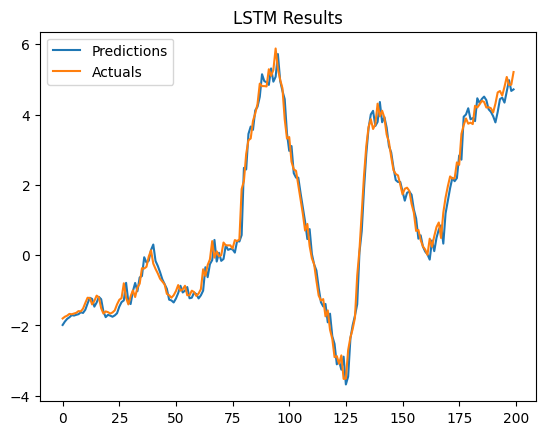

In [176]:
# Testing the LSTM model 
predictions_multi_variables = LSTM_model_multi_variables.predict(Input_test_multi_variables).flatten()
results_multi_variables = pd.DataFrame(data={'Predictions':predictions_multi_variables, 'Actuals':Output_test_multi_variables})

# Ploting the Results of 200 example
plt.plot(results_multi_variables['Predictions'][:200], label="Predictions")
plt.plot(results_multi_variables['Actuals'][:200], label="Actuals")
plt.legend(loc="upper left")
plt.title("LSTM Results")

In [177]:
# Adding presure in DataFrame

presure_temprature_DataFrame = pd.concat([DataFrame['p (mbar)'], temprature_DataFrame], axis=1)
presure_temprature_DataFrame.head()

,p (mbar),Temperature,Day sin,Day cos,Year sin,Year cos
Date Time,,,,,,
2009-01-01 00:10:00,996.52,-8.02,0.043619,0.999048,0.009452,0.999955
2009-01-01 00:40:00,996.51,-8.31,0.173648,0.984808,0.009810,0.999952
2009-01-01 01:10:00,996.50,-7.62,0.300706,0.953717,0.010169,0.999948
2009-01-01 01:40:00,996.53,-8.43,0.422618,0.906308,0.010527,0.999945
2009-01-01 02:10:00,996.63,-8.85,0.537300,0.843391,0.010885,0.999941


In [178]:
# Making input (X) and output (Y) from Dataset
#print(presure_temprature_DataFrame)

windiw_size = 7
Input_multi_output, Output_multi_output = DataFrame_to_input_output(presure_temprature_DataFrame, windiw_size, variate="multi_Output")

Input_multi_output.shape, Output_multi_output.shape

((140177, 7, 6), (140177, 2))

In [179]:
# Data Split

Input_train_multi_output, Output_train_multi_output = Input_multi_output[:120000], Output_multi_output[:120000]
Input_val_multi_output, Output_val_multi_output = Input_multi_output[120000:125000], Output_multi_output[120000:125000]
Input_test_multi_output, Output_test_multi_output = Input_multi_output[125000:], Output_multi_output[125000:]



print(Input_train_multi_output.shape, Output_train_multi_output.shape)
print(Input_val_multi_output.shape, Output_val_multi_output.shape)
print(Input_test_multi_output.shape, Output_test_multi_output.shape)

(120000, 7, 6) (120000, 2)
(5000, 7, 6) (5000, 2)
(15177, 7, 6) (15177, 2)


In [180]:
# Standardization Input and Output


P_Input_train_mean = np.mean(Input_train_multi_output[:, :, 0])
P_Input_train_std = np.std(Input_train_multi_output[:, :, 0])
T_Input_train_mean = np.mean(Input_train_multi_output[:, :, 1])
T_Input_train_std = np.std(Input_train_multi_output[:, :, 1])

def preprocessing_data_input(data):
    data[:, :, 0] = (data[:, :, 0] - P_Input_train_mean) / P_Input_train_std
    data[:, :, 1] = (data[:, :, 1] - T_Input_train_mean) / T_Input_train_std
    return data
def preprocessing_data_output(data):
    data[:, 0] = (data[:, 0] - P_Input_train_mean) / P_Input_train_std
    data[:, 1] = (data[:, 1] - T_Input_train_mean) / T_Input_train_std
    return data
    
# Preprocessing Train, Val, Test Data
Input_train_multi_output = preprocessing_data_input(Input_train_multi_output)
Input_val_multi_output = preprocessing_data_input(Input_val_multi_output)
Input_test_multi_output = preprocessing_data_input(Input_test_multi_output)

Output_train_multi_output = preprocessing_data_output(Output_train_multi_output)
Output_val_multi_output = preprocessing_data_output(Output_val_multi_output)
Output_test_multi_output = preprocessing_data_output(Output_test_multi_output)

print(Input_train_multi_output.shape, Output_train_multi_output.shape)
print(Input_val_multi_output.shape, Output_val_multi_output.shape)
print(Input_test_multi_output.shape, Output_test_multi_output.shape)

(120000, 7, 6) (120000, 2)
(5000, 7, 6) (5000, 2)
(15177, 7, 6) (15177, 2)


In [181]:
# Defining LSTM Model

LSTM_model_multi_output = Sequential()
LSTM_model_multi_output.add(InputLayer((7, 6)))
LSTM_model_multi_output.add(LSTM(64))
LSTM_model_multi_output.add(Dense(8, 'relu'))
LSTM_model_multi_output.add(Dense(2, 'linear'))

# Loss and optimizer
LSTM_model_multi_output.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

LSTM_model_multi_output.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 64)                18176     
_________________________________________________________________
dense_38 (Dense)             (None, 8)                 520       
_________________________________________________________________
dense_39 (Dense)             (None, 2)                 18        
Total params: 18,714
Trainable params: 18,714
Non-trainable params: 0
_________________________________________________________________


In [182]:
# Training LSTM model
LSTM_model_multi_output.fit(Input_train_multi_output, Output_train_multi_output, validation_data=(Input_val_multi_output, Output_val_multi_output), epochs=10)

Epoch 1/10
3750/3750 [==============================] - 28s 7ms/step - loss: 0.0451 - root_mean_squared_error: 0.1803 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0407
Epoch 2/10
3750/3750 [==============================] - 28s 8ms/step - loss: 0.0030 - root_mean_squared_error: 0.0543 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0399
Epoch 3/10
3750/3750 [==============================] - 37s 10ms/step - loss: 0.0027 - root_mean_squared_error: 0.0519 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0401
Epoch 4/10
3750/3750 [==============================] - 30s 8ms/step - loss: 0.0023 - root_mean_squared_error: 0.0479 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0381
Epoch 5/10
3750/3750 [==============================] - 32s 9ms/step - loss: 0.0025 - root_mean_squared_error: 0.0499 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0374
Epoch 6/10
3750/3750 [==============================] - 23s 6ms/step - loss: 0.0020 - root_mean_squared_error: 0.0444 - val_

Text(0.5, 1.0, 'LSTM Results')

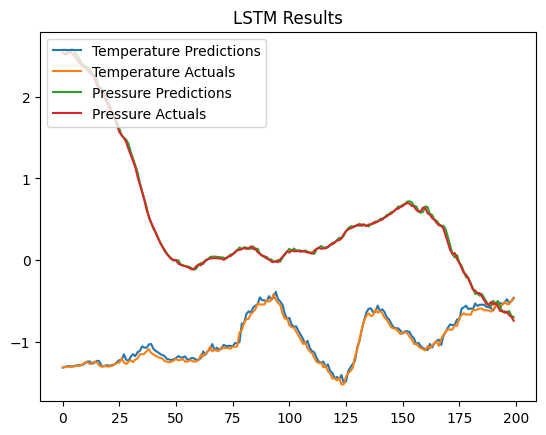

In [183]:
# Testing the LSTM model 
predictions = LSTM_model_multi_output.predict(Input_test_multi_output)
predictions_P, predictions_T = predictions[:,0], predictions[:,1]
actuals_P, actuals_T = Output_test_multi_output[:,0], Output_test_multi_output[:,1]

results = pd.DataFrame(data={'Temperature Predictions':predictions_T, 
                             'Temperature Actuals':actuals_T,
                             'Pressure Predictions':predictions_P, 
                             'Pressure Actuals':actuals_P,
                             })

# Ploting the Results of 200 example
plt.plot(results['Temperature Predictions'][:200], label="Temperature Predictions")
plt.plot(results['Temperature Actuals'][:200], label="Temperature Actuals")
plt.plot(results['Pressure Predictions'][:200], label="Pressure Predictions")
plt.plot(results['Pressure Actuals'][:200], label="Pressure Actuals")
plt.legend(loc="upper left")
plt.title("LSTM Results")

In [184]:
# Post Processing

def post_processing_temprature(data):
    data = (data*T_Input_train_std) + T_Input_train_mean
    return data

def post_processing_presure(data):
    data = (data*P_Input_train_std) + P_Input_train_mean
    return data


Text(0.5, 1.0, 'Temprature Results with LSTM')

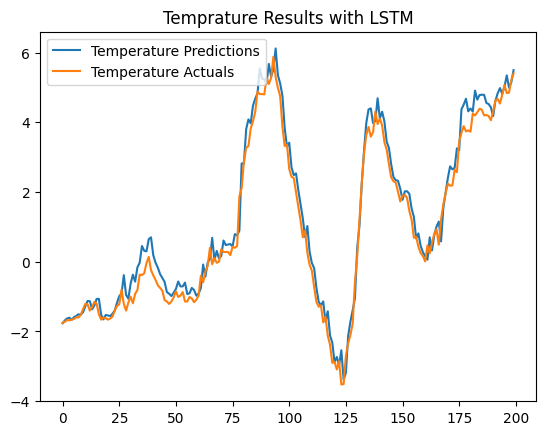

In [185]:
# Testing the LSTM model with Temprature and Presure seprate

predictions = LSTM_model_multi_output.predict(Input_test_multi_output)
predictions_P, predictions_T = post_processing_presure(predictions[:,0]), post_processing_temprature(predictions[:,1])
actuals_P, actuals_T = post_processing_presure(Output_test_multi_output[:,0]), post_processing_temprature(Output_test_multi_output[:,1])

results = pd.DataFrame(data={'Temperature Predictions':predictions_T, 
                             'Temperature Actuals':actuals_T,
                             'Pressure Predictions':predictions_P, 
                             'Pressure Actuals':actuals_P,
                             })

# Ploting the Results of temprature 200 example 
plt.plot(results['Temperature Predictions'][:200], label="Temperature Predictions")
plt.plot(results['Temperature Actuals'][:200], label="Temperature Actuals")
plt.legend(loc="upper left")
plt.title("Temprature Results with LSTM")



Text(0.5, 1.0, 'Presure Results with LSTM')

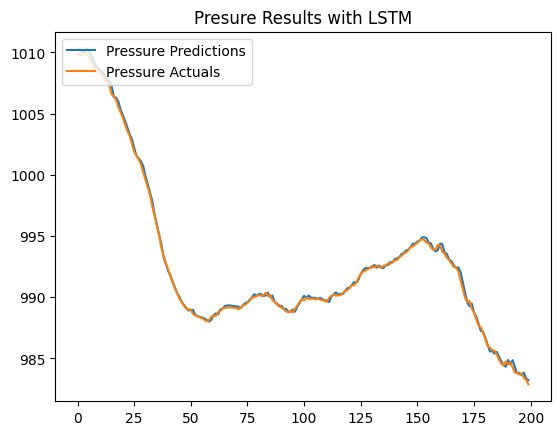

In [186]:
# Ploting the Results of presure 200 example

plt.plot(results['Pressure Predictions'][:200], label="Pressure Predictions")
plt.plot(results['Pressure Actuals'][:200], label="Pressure Actuals")
plt.legend(loc="upper left")
plt.title("Presure Results with LSTM")

In [188]:
# Defining CNN Model for Multiple Outputs

CNN_model_multi_output = Sequential()
CNN_model_multi_output.add(InputLayer((7, 6)))
CNN_model_multi_output.add(Conv1D(64, kernel_size=2, activation='relu'))
CNN_model_multi_output.add(Flatten())
CNN_model_multi_output.add(Dense(8, 'relu'))
CNN_model_multi_output.add(Dense(2, 'linear'))

# Loss and optimizer
CNN_model_multi_output.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

CNN_model_multi_output.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 6, 64)             832       
_________________________________________________________________
flatten_3 (Flatten)          (None, 384)               0         
_________________________________________________________________
dense_40 (Dense)             (None, 8)                 3080      
_________________________________________________________________
dense_41 (Dense)             (None, 2)                 18        
Total params: 3,930
Trainable params: 3,930
Non-trainable params: 0
_________________________________________________________________


In [189]:
# Training CNN model
CNN_model_multi_output.fit(Input_train_multi_output, Output_train_multi_output, validation_data=(Input_val_multi_output, Output_val_multi_output), epochs=10)

Epoch 1/10
3750/3750 [==============================] - 9s 2ms/step - loss: 0.0308 - root_mean_squared_error: 0.1504 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0449
Epoch 2/10
3750/3750 [==============================] - 7s 2ms/step - loss: 0.0028 - root_mean_squared_error: 0.0528 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0479
Epoch 3/10
3750/3750 [==============================] - 7s 2ms/step - loss: 0.0025 - root_mean_squared_error: 0.0494 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0421
Epoch 4/10
3750/3750 [==============================] - 8s 2ms/step - loss: 0.0025 - root_mean_squared_error: 0.0501 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0467
Epoch 5/10
3750/3750 [==============================] - 8s 2ms/step - loss: 0.0023 - root_mean_squared_error: 0.0479 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0425
Epoch 6/10
3750/3750 [==============================] - 7s 2ms/step - loss: 0.0021 - root_mean_squared_error: 0.0462 - val_loss: 0